# 現状整理

- 最新のノートブックは note9.ipynb
  - シミュレーションだけ、実機無し
- note10.ipynb で実機データ読み込んだ結果
  - dt が一定ではないので、モデルに dt を組み込んだ実装が必要

### 用語区別

- `v_s`: 入力電圧
- `v_p`: スイッチング電圧
- `v_a`: 実効電圧
- `u`: スイッチング信号
- `v_c`: 出力電圧 (= v_o だが、v_c に統一する)

とする

# NA

- dt をモデルに組み込んだ実装
- 実機データで学習させる
- ホイン法で note9 の再現
- GRU を含めた実装

# さらに

- プッシュプルコンバータのデータの学習でスイッチング直後の乱れを GRU でシミュレーションできるか確認する


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)


# モデルに dt を組み込む


In [2]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self,
        h: torch.Tensor,
        vs: torch.Tensor,
        u: torch.Tensor,
        dt: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # h: [batch, 2] - [iL, vC]

        iL = h[:, 0]
        vC = h[:, 1]

        vs_tensor = torch.as_tensor(vs, dtype=iL.dtype, device=iL.device)
        u_tensor = torch.as_tensor(u, dtype=iL.dtype, device=iL.device)
        vp = vs_tensor * u_tensor
        dt_tensor = torch.as_tensor(dt, dtype=iL.dtype, device=iL.device)

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # DCM対応
        va = torch.where((vp == 0) & (iL <= 0), vC, vp)

        # オイラー法
        iL_next = iL + (dt_tensor / L) * (va - vC)
        iL_next = torch.relu(iL_next)  # 電流は負にならない（DCM考慮）

        vC_next = vC + (dt_tensor / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1), va

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }

# 学習データの入力波形作成

- dt を不規則にする


In [3]:
# 真値パラメータ（すべてのデータセットで共通）
L_true = 100e-6
C_true = 48e-6
R_true = 10

Vin = 28
Vref = 6
duty = Vref / Vin
_f_sw = 20e3  # スイッチング周波数(仮)
cycles = 500  # 1周期分のシミュレーションを何回繰り返すか
dt_list = [1.9e-7, 2.0e-7, 2.1e-7]


In [4]:
# f_sw に合わせて約1周期分の dt をランダムに選ぶ
dt_one_list = []
cum = 0.0
while cum < 1 / _f_sw:
    _dt = np.random.choice(dt_list)
    dt_one_list.append(_dt)
    cum += _dt
dt_one = np.asarray(dt_one_list, dtype=float)


# 1周期分のシミュレーションをcycles分複製して拡張
dt = np.tile(dt_one, cycles)

t = np.concatenate(([0.0], np.cumsum(dt)))


print(f"{Vin=}")
print(f"{Vref=}")
print(f"{duty=}")
print(f"{dt[:10]=}")
print(f"{len(dt)=}")
print(f"サンプリング周波数: {1 / sum(dt_one)}")
print(f"1周期のサンプル数: {len(dt_one)}")
print(f"サンプリング数: {len(dt)}")
print(f"シミュレーション時間(s): {sum(dt)}")


Vin=28
Vref=6
duty=0.21428571428571427
dt[:10]=array([2.0e-07, 2.0e-07, 1.9e-07, 1.9e-07, 2.0e-07, 1.9e-07, 2.0e-07,
       2.0e-07, 1.9e-07, 2.0e-07])
len(dt)=125500
サンプリング周波数: 19944.156362185866
1周期のサンプル数: 251
サンプリング数: 125500
シミュレーション時間(s): 0.025070000000014338


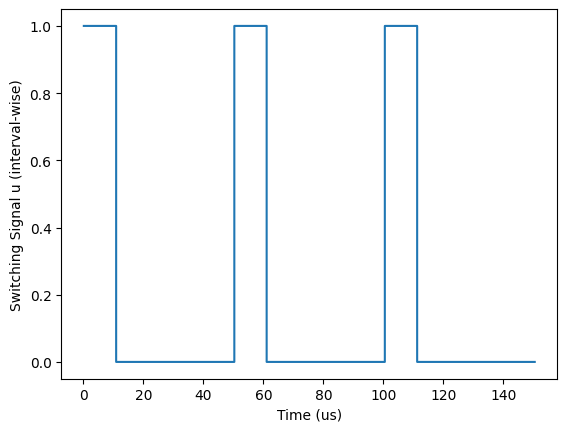

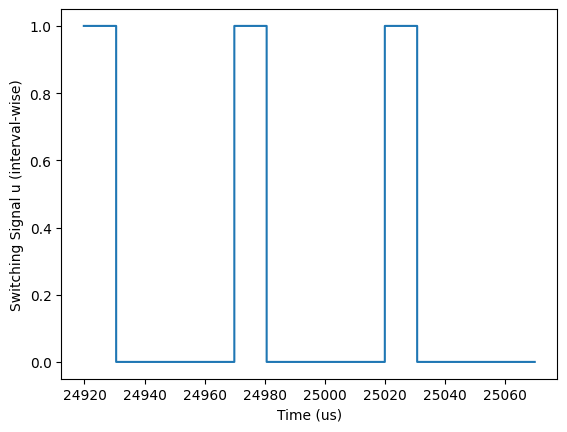

In [5]:
# スイッチング信号（不規則 dt 対応：時間基準でPWM生成）
T = np.sum(dt_one)  # 1周期の実時間
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(dt)) * Vin


# プロット
_t = t[1:]
plot_range = min(len(dt_one) * 3, len(_t))

plt.step(_t[:plot_range] * 1e6, u[:plot_range], where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u (interval-wise)")
plt.show()

plt.step(_t[-plot_range:] * 1e6, u[-plot_range:], where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u (interval-wise)")
plt.show()


# BuckConverterCell を使ってシミュレーションデータを作成


In [6]:
# モデルを作成
model_true = BuckConverterCell(L_init=L_true, C_init=C_true, R_init=R_true)

va_list = []
il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current = torch.zeros(1, 2)  # [iL=0, vC=0]
    for j in range(len(dt)):
        # 現在の状態を保存
        il_list.append(h_current[0, 0].item())  # iL
        vc_list.append(h_current[0, 1].item())  # vC

        h_current, va = model_true(h_current, vs[j], u[j], dt[j])
        va_list.append(va[0].item())


va = torch.tensor(np.array(va_list), dtype=torch.float32).unsqueeze(1)
iL = torch.tensor(np.array(il_list), dtype=torch.float32)
vC = torch.tensor(np.array(vc_list), dtype=torch.float32)

print(va.shape)
print(iL.shape)
print(vC.shape)


torch.Size([125500, 1])
torch.Size([125500])
torch.Size([125500])


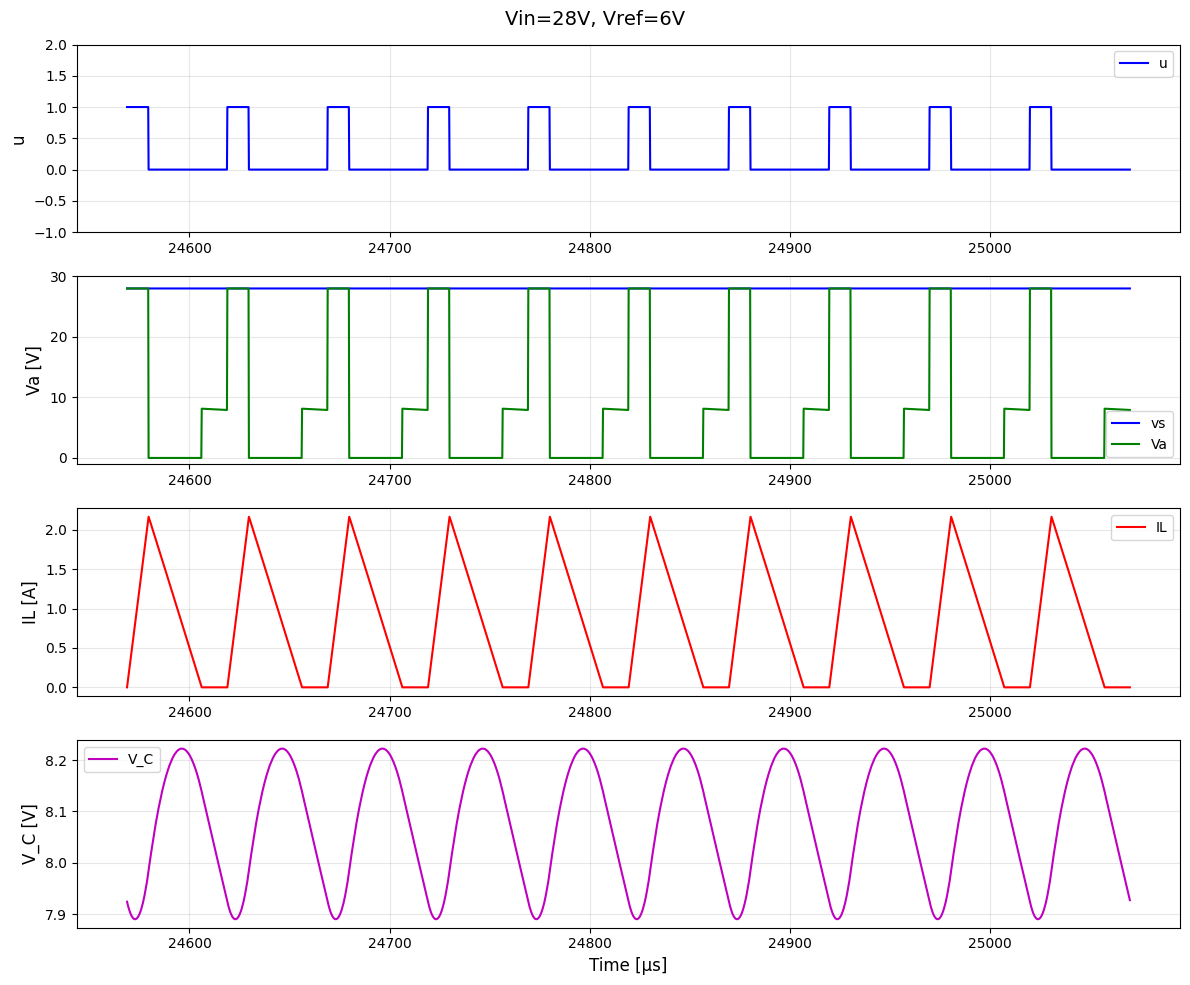

In [7]:
# 生成したデータセットのサンプルを可視化
plot_range = len(dt_one) * 10


fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# タイトル
fig.suptitle(f"Vin={Vin}V, Vref={Vref}V", fontsize=14)
_t = t[1:]

# u
axes[0].plot(_t[-plot_range:] * 1e6, u[-plot_range:], "b-", linewidth=1.5, label="u")
axes[0].set_ylabel("u", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, 2)
axes[0].legend()

# v_s
axes[1].plot(_t[-plot_range:] * 1e6, vs[-plot_range:], "b-", linewidth=1.5, label="vs")
axes[1].set_ylabel("vs [V]", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1, Vin + 2)
axes[1].legend()

# va (実効電圧、DCM対応)
axes[1].plot(
    _t[-plot_range:] * 1e6,
    va[-plot_range:],
    "g-",
    linewidth=1.5,
    label="Va",
)
axes[1].set_ylabel("Va [V]", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1, Vin + 2)
axes[1].legend()

# il (インダクタ電流)
axes[2].plot(
    _t[-plot_range:] * 1e6,
    iL[-plot_range:],
    "r-",
    linewidth=1.5,
    label="IL",
)
axes[2].set_ylabel("IL [A]", fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# vc (出力電圧)
axes[3].plot(
    _t[-plot_range:] * 1e6,
    vC[-plot_range:],
    "m-",
    linewidth=1.5,
    label="V_C",
)
axes[3].set_ylabel("V_C [V]", fontsize=12)
axes[3].set_xlabel("Time [µs]", fontsize=12)
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()

# 初期値を解析的に決めてみる


### R

定常状態では、以下の近似が成り立つと仮定

$$
i_L(t+\Delta t) \approx i_L(t)
$$

$$
v_C(t+\Delta t) \approx v_C(t)
$$

オイラー法の式に代入

> $$v_C(t + \Delta t) = v_C(t) + \frac{\Delta t}{C} \left( i_L - \frac{v_C}{R} \right)$$

$$
0 = \frac{\Delta t}{C}\left(i_L - \frac{v_C}{R}\right)
$$

$$
R \approx \frac{v_C}{i_L}
$$

### L

> $$i_L(t+\Delta t) = i_L(t) + \frac{\Delta t}{L} (V_{in}u(t)-v_C(t))$$

$$
\Delta i_L = i_L(t+\Delta t)-i_L(t)
$$

$$
x = \Delta t (V_{in}u(t)-v_C(t))
$$

とおいたとき、

$$
\Delta i_L = \frac{1}{L} \cdot x
$$

となるので、これを最小二乗法で解くと、

$$
\frac{1}{L} = \frac{\sum \Delta i_L \cdot x}{\sum x^2}
$$

### C

> $$v_C(t+\Delta t) = v_C(t) + \frac{\Delta t}{C}\left(i_L(t)-\frac{v_C(t)}{R}\right)$$

$$
\Delta v_C = v_C(t+\Delta t) - v_C(t)
$$

$$
z = \Delta t\left(i_L - \frac{v_C}{R_0}\right)
$$

とおいたとき、これを最小二乗法で解くと、

$$
\Delta v_C = \frac{1}{C} z
$$

$$
\frac{1}{C} = \frac{\sum \Delta v_C \cdot z}{\sum z^2}
$$

In [8]:
iL_np = iL.numpy()
vC_np = vC.numpy()
va_np = va.squeeze(1).numpy()
dt_np = dt


# R 粗同定
R0 = (vC.mean() / iL.mean()).item()
print("R0 (coarse):", R0)


# L 粗同定
di = iL_np[1:] - iL_np[:-1]  # Δi_L
x = dt_np[:-1] * (va_np[:-1] - vC_np[:-1])  # Δt * (va - vC)

L0 = np.sum(x * x) / np.sum(di * x)
print("L0 (coarse):", L0)


# C 粗同定
dv = vC_np[1:] - vC_np[0:-1]
z = dt_np[:-1] * (iL_np[:-1] - vC_np[:-1] / R0)

C0 = np.sum(z * z) / np.sum(dv * z)
print("C0 (coarse):", C0)


R0 (coarse): 9.808077812194824
L0 (coarse): 0.00010005941334392786
C0 (coarse): 4.801188813106086e-05


# 学習率


In [9]:
lr_L = 1e-4
lr_C = 3e-4
lr_R = 2e-4

# 学習


In [10]:
iL_train = iL[-plot_range:]
vC_train = vC[-plot_range:]
vs_train = vs[-plot_range:]
u_train = u[-plot_range:]
dt_train = dt[-plot_range:]

epochs = 500

model = BuckConverterCell(L_init=L0, C_init=C0, R_init=R0)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

loss_history = []
param_history = {"L": [], "C": [], "R": [], "log_L": [], "log_C": [], "log_R": []}

# 学習データの準備 - 次ステップ予測のためのペアを作成
h_seq = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)  # 現在の状態
h_target = torch.stack([iL_train[1:], vC_train[1:]], dim=1)  # 次時刻の状態


# 学習ループ
for epoch in range(epochs):
    optimizer.zero_grad()
    h_pred, _ = model(h_seq, vs_train[:-1], u_train[:-1], dt_train[:-1])
    loss = loss_fn(h_pred, h_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])
    param_history["log_L"].append(params["log_L"])
    param_history["log_C"].append(params["log_C"])
    param_history["log_R"].append(params["log_R"])

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Loss={loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={params['R']:.2f}Ω (true={R_true:.1f})"
        )
else:
    print("学習完了")
    print(
        f"Epoch {epoch}: Loss={loss.item():.6e}  "
        f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
        f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
        f"R={params['R']:.2f}Ω (true={R_true:.1f})"
    )


Epoch 0: Loss=2.249653e-09  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=9.81Ω (true=10.0)
Epoch 50: Loss=6.366871e-10  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=9.90Ω (true=10.0)
Epoch 100: Loss=1.219674e-10  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=9.95Ω (true=10.0)
Epoch 150: Loss=1.467054e-11  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=9.98Ω (true=10.0)
Epoch 200: Loss=1.137593e-12  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 250: Loss=1.096541e-13  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 300: Loss=2.174958e-14  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 350: Loss=3.171813e-15  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 400: Loss=3.171813e-15  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 450: Loss=3.171813e-15  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R=10.00Ω (true=10.0)
学習完了
Epoch 499: Loss=3.171813e-15  L=

# 結果


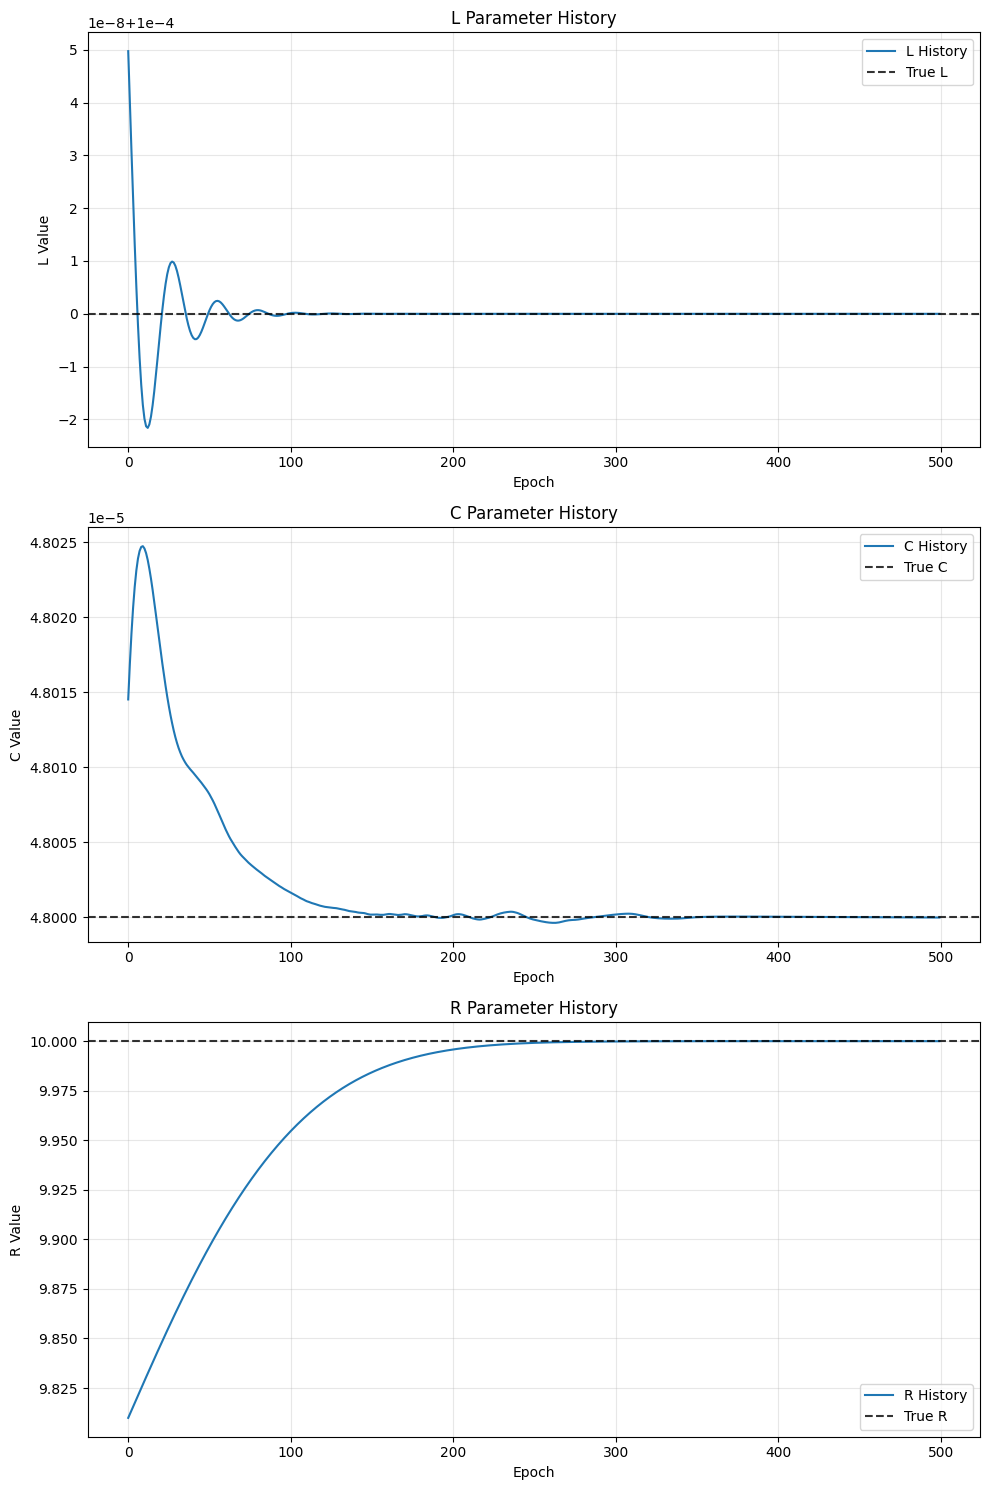

In [11]:
# 各パラメータの遷移
plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=L_true, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=C_true, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=R_true, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# シミュレーションしてみる
with torch.no_grad():
    h_sim = [torch.zeros(1, 2)]
    for i in range(1, len(dt)):
        h_next, _ = model(h_sim[-1], vs[i], u[i], dt[i])
        h_sim.append(h_next)
    h_sim = torch.cat(h_sim, dim=0)

il_sim = h_sim[:, 0].numpy()
vc_sim = h_sim[:, 1].numpy()


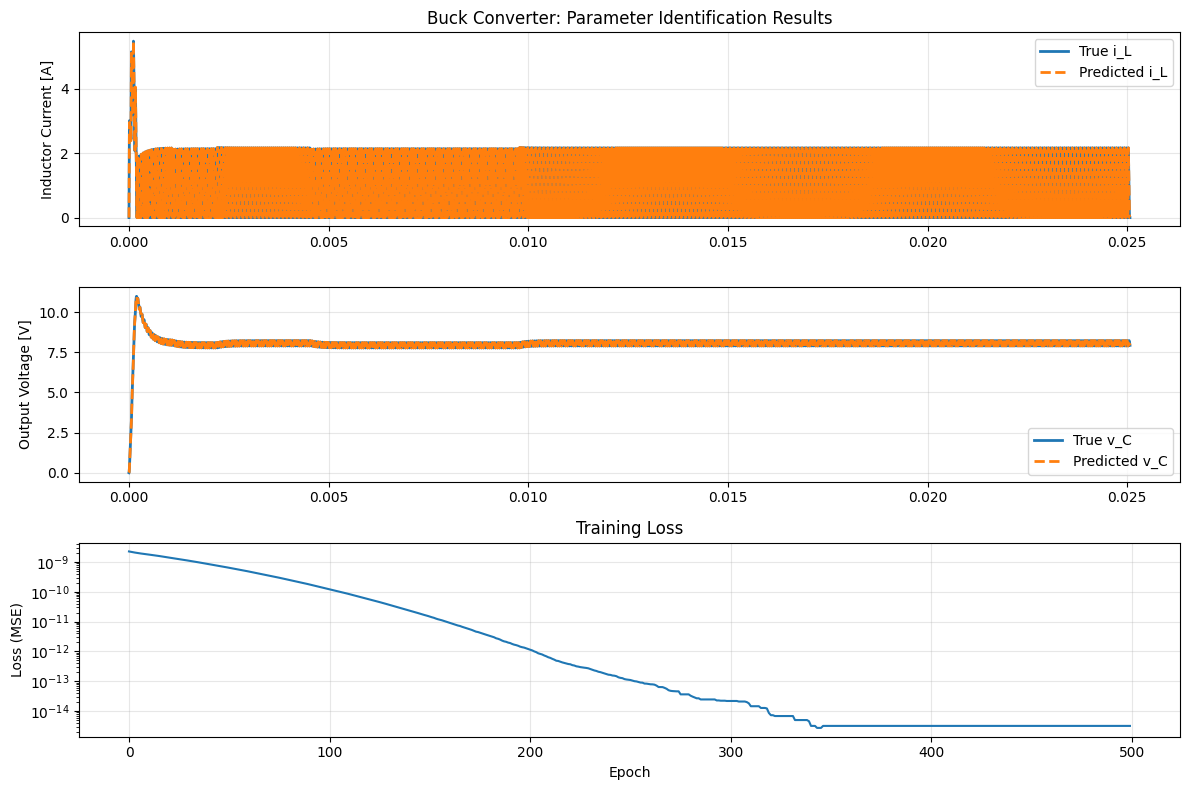

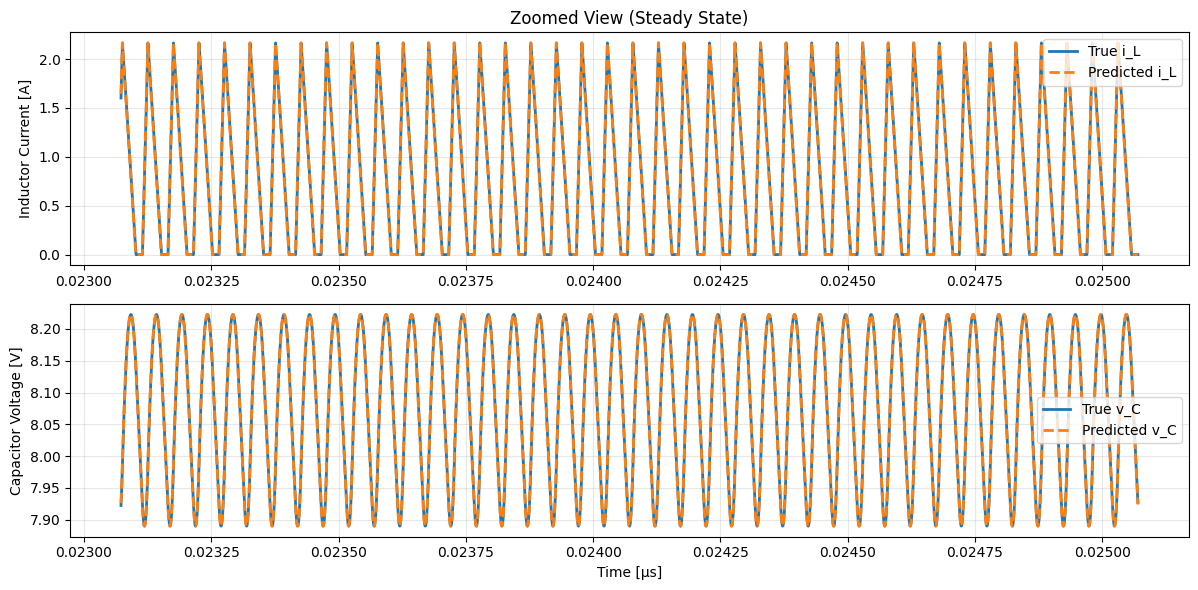

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

_t = t[1:]

# インダクタ電流
axes[0].plot(_t, iL, label="True i_L", linewidth=2)
axes[0].plot(_t, il_sim, "--", label="Predicted i_L", linewidth=2)
axes[0].set_ylabel("Inductor Current [A]")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Buck Converter: Parameter Identification Results")

# キャパシタ電圧
axes[1].plot(_t, vC, label="True v_C", linewidth=2)
axes[1].plot(_t, vc_sim, "--", label="Predicted v_C", linewidth=2)
axes[1].set_ylabel("Output Voltage [V]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 損失関数の履歴
axes[2].semilogy(loss_history)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss (MSE)")
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Training Loss")

plt.tight_layout()
plt.show()

# 一部区間の詳細表示
plt.figure(figsize=(12, 6))
start_idx = len(_t) - 10000
end_idx = len(_t)

plt.subplot(2, 1, 1)
plt.plot(_t[start_idx:end_idx], iL[start_idx:end_idx], label="True i_L", linewidth=2)
plt.plot(
    _t[start_idx:end_idx],
    il_sim[start_idx:end_idx],
    "--",
    label="Predicted i_L",
    linewidth=2,
)
plt.ylabel("Inductor Current [A]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Zoomed View (Steady State)")

plt.subplot(2, 1, 2)
plt.plot(_t[start_idx:end_idx], vC[start_idx:end_idx], label="True v_C", linewidth=2)
plt.plot(
    _t[start_idx:end_idx],
    vc_sim[start_idx:end_idx],
    "--",
    label="Predicted v_C",
    linewidth=2,
)
plt.ylabel("Capacitor Voltage [V]")
plt.xlabel("Time [µs]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# まとめ

- dt をモデルに組み込んだ実装できた
- 定常状態の 10 周期分の学習データがあると仮定
- 粗同定でざっくり回路パラメータを求め、それを初期値として学習
